# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Описание полей данных:**

- BeginDate — дата начала пользования услугами
- EndDate — дата окончания пользования услугами
- Type — тип оплаты: ежемесячный, годовой и тд
- PaperlessBilling — электронный платежный документ
- PaymentMethod — способ оплаты
- MonthlyCharges — ежемесячные траты на услуги
- Dependents — наличие иждивенцев
- Senior Citizen — наличие пенсионного статуса по возрасту
- Pertner — наличие супруга(и)
- MultipleLines —  наличие возможности ведения параллельных линий во время звонка
---

Из описания задачи делаем **вывод**, что:

Перед нами стоит задача бинарной классификации (ушел/не ушел), метрика у нас AUC-ROC > 0.85 Бизнес-метрика здесь — это убытки по двум направлениям: 

1. пользователю предложили промокоды, но он не собирался уходить (false positive), 
2. пользователю ничего не предложили и он ушёл (false negative).

Так как величина промокода пока неизвестна, используем метрику, которая учитывает возможность балансировать между этими (false posititve и false negative) — AUC-ROC.<br>
В качестве дополнительной метрики так же вычислим accuracy.

Посмотрим на данные. Проведем исследовательский анализ. В конце составим список уточняющих вопросов для тимлида, примерный план решения задачи, с описанием шагов.

## Часть 1

### Разведывательный анализ

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

from lightgbm import LGBMClassifier
from phik import report
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

warnings.filterwarnings("ignore")

RANDOM_STATE = 80523

In [2]:
try:
    contract = pd.read_csv('datasets/telecom/contract_new.csv')
    internet = pd.read_csv('datasets/telecom/internet_new.csv')
    personal = pd.read_csv('datasets/telecom/personal_new.csv')
    phone = pd.read_csv('datasets/telecom/phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
def check(df):
    print(df.info(), '\n')
    print('Pass:\n', df.isna().sum(), '\n')
    print('Duplicates:', df.duplicated().sum())
    display(df.sample(5))
    print('-'*120)
    
    empty_col = []
    for col in df.columns:
        print(col)
        print(df[col].unique())
        print('Count of unique values:',df[col].nunique(), '\n')
        
        if ' ' in list(df[col].unique()):
            empty_col.append(col)
            
    print('There are empty rows'.upper())
    print(empty_col)
    
    return

In [4]:
check(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 

Pass:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Duplicates: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4334,3969-GYXEL,2019-03-01,No,Month-to-month,No,Electronic check,76.40,874.02
2919,1936-CZAKF,2016-01-01,No,Two year,No,Credit card (automatic),49.65,2432.85
6974,0422-UXFAP,2015-11-01,No,One year,Yes,Electronic check,98.85,5041.35
5605,8049-WJCLQ,2019-04-01,No,Month-to-month,No,Mailed check,60.20,638.12
2178,1657-DYMBM,2015-09-01,No,Two year,No,Credit card (automatic),19.90,1107.43


------------------------------------------------------------------------------------------------------------------------
customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Count of unique values: 7043 

BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2

В описании данных нет пояснения значения `TotalCharges`. Очевидно, исходя из столбца - `MonthlyCharges`, речь идет о всех тратах пользователя с начало пользования услугами, то есть с `BeginDate`, до `EndDate` или же 1 февраля 2020 (актуальность данных).

Типы столбцов - *object* за исключением `MonthlyCharges`. Необходимо будет исправить. Категориальные признаки `BeginDate`, `EndDate`, `PaperlessBilling` на типы данных *datetime*, *bool* или же *0* и *1*, `TotalCharges` на тип *float*.

Пропусков **явных** нет, но видим, что в столбце `EndDate` есть **записи со значением** *No*. Вероятнее всего, это означает, что пользователь является клиентом по сей день (на момент актуальности данных).

Явных дубликатов - ноль. Неявных тоже нет. По уникальным значениям времени делает вывод, что это месяца.

upd:
При дальнейшем анализе заметили "своеобразные" пропуски - пустые строки.

In [5]:
#contract.loc[contract['TotalCharges'] == ' ']

Данные пустые строки появились  из-за того, что **актуальность на 2020-02-01, а эти пользователи стали клиентами в этот же месяц.** <br>
**Заменим** на *0* эти пустые строки.

In [6]:
#contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [7]:
check(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None 

Pass:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Duplicates: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
762,4208-UFFGW,DSL,No,No,No,No,No,No
4956,1025-FALIX,Fiber optic,No,No,No,No,No,No
272,4322-RCYMT,DSL,No,Yes,Yes,Yes,No,Yes
4039,3672-YITQD,Fiber optic,No,No,No,No,No,Yes
39,3714-NTNFO,Fiber optic,No,No,No,No,No,Yes


------------------------------------------------------------------------------------------------------------------------
customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Count of unique values: 5517 

InternetService
['DSL' 'Fiber optic']
Count of unique values: 2 

OnlineSecurity
['No' 'Yes']
Count of unique values: 2 

OnlineBackup
['Yes' 'No']
Count of unique values: 2 

DeviceProtection
['No' 'Yes']
Count of unique values: 2 

TechSupport
['No' 'Yes']
Count of unique values: 2 

StreamingTV
['No' 'Yes']
Count of unique values: 2 

StreamingMovies
['No' 'Yes']
Count of unique values: 2 

THERE ARE EMPTY ROWS
[]


Явного описания данных по данной таблице нет. Но нам известно, что доступны такие услуги:

>"Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
>Выделенная линия технической поддержки (TechSupport);
>Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
>Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)."

А также, что 
>"подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic)."

Все встало на свои места. В таблице указан тип подключения интернета у клиента, а также пакет подключенных услуг. 
В данной таблице лучше заменить тип *object* для столбцов с услугами на *0* и *1*.

Явных пропусков и дубликатов - нет. Неявных дубликатов и пропусков нет.

In [8]:
check(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None 

Pass:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Duplicates: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
788,0810-BDHAW,Female,0,Yes,Yes
5280,6574-MCOEH,Female,0,Yes,Yes
765,4718-DHSMV,Female,0,No,No
4272,1043-YCUTE,Male,0,Yes,No
3292,7284-BUYEC,Female,0,No,No


------------------------------------------------------------------------------------------------------------------------
customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Count of unique values: 7043 

gender
['Female' 'Male']
Count of unique values: 2 

SeniorCitizen
[0 1]
Count of unique values: 2 

Partner
['Yes' 'No']
Count of unique values: 2 

Dependents
['No' 'Yes']
Count of unique values: 2 

THERE ARE EMPTY ROWS
[]


Аналогичная ситуация. Тип данных на bool или *0*, *1*. А также исправить тип в столбце `SeniorCitizen`. <br> Пропусков и дубликатов тоже нет. Неявных дубликатов и пропусков нет.

In [9]:
check(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None 

Pass:
 customerID       0
MultipleLines    0
dtype: int64 

Duplicates: 0


,customerID,MultipleLines
885,6646-QVXLR,Yes
3122,4450-DLLMH,No
5050,2270-CHBFN,Yes
3612,2920-RNCEZ,No
1919,2911-WDXMV,Yes


------------------------------------------------------------------------------------------------------------------------
customerID
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
Count of unique values: 6361 

MultipleLines
['No' 'Yes']
Count of unique values: 2 

THERE ARE EMPTY ROWS
[]


Аналогично ситуациям выше. Тип данных на *bool* или *0, 1*. Пропусков и дубликатов тоже нет. Неявных дубликатов и пропусков нет.

Исходя из общего анализа всех датасетов **подведем вывод**:
1. Основная "проблема" - это типы данных. Следует заменить их там, где это требуется.
2. В датасете **`contract`** пропусков явных нет, но в столбце `EndDate` есть записи со значением No. Это означает, что пользователь является клиентом по сей день (на момент актуальности данных). Учтем это  при дальнейшем анализе. По уникальным значениям времени сделали вывод, что это распределение по месяцам.
3. Не по всем пользователям есть информация в каждом датасете. Имеются различия в количестве уникальных пользователей.


При этом, **вопросы** для тимлида:<br>
Вопросов нет.

**План решения задачи:**
1. Подготовим данные к анализу. <br>
    1.1. Заменим на верные типы данных значения в столбцах наших датасетов. Этот шаг нужен для удобной и безошибочной работы с данными, а также при подготовки модели.<br>
    1.2. Проверим количественные данные на аномалии. Если имеются аномалии, выясним их природу.<br>
    1.3. Выберем наиболее информативные столбцы из датасетов. Объединим выборки. Обязательно проследим, чтобы данные "не потерялись", то есть чтобы не возникло пропусков. Выделим таргет.<br>
    
2. Проанализируем данные (EDA).<br>
    2.1. Посмотрим на различные распределения количественных признаков и категориальных признаков. Визуализируем данные.<br>
    2.2. Проведем анализ на мультиколлениарность признаков.<br>
    2.3. Проверим дисбаланс классов.<br>
    
3. Подготовим признаки для подачи в модель.  <br>
    3.1. Разделим данные на *train* и *test* в отношении *train_size=0.75*.  <br>
    3.2. Для линейной модели - проведем энкодинг (ohe), нормализацию, стандартизацию, с помощью Pipeline. Другим моделям подадим данные без обработки ohe. <br>
    
4. Построим модели. <br>
    4.1 Подберем гиперпараметры с помощью *GridSerchCV* или же *RandomisedSearchCV*. Посмотрим на значения метрик на кросс-валидации.<br>

5. Тест модели на тестовых данных. <br>

6. Проведем анализ важности признаков, построим матрицу ошибок.

Примечание: <br>
Т.к. мы планируем использовать кодировщик, категориальные данные оставим без изменений.

## Часть 2

### Шаг 1

Пункт 1.1 <br>
Разбираемся с типами данных.

In [10]:
contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
569,0308-IVGOK,2019-03-01,No,One year,Yes,Credit card (automatic),40.40,457.73
3854,0237-YFUTL,2015-12-01,No,Month-to-month,Yes,Bank transfer (automatic),109.65,5482.5
4932,5566-SOEZD,2017-11-01,No,One year,Yes,Credit card (automatic),80.65,2177.55


In [11]:
contract.loc[contract['EndDate'] == '2020-02-01'].shape[0]

0

In [12]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01' #заглушка
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

In [13]:
contract.loc[contract['EndDate'] == '2020-02-01'].shape[0]

5942

In [14]:
#contract.loc[contract['PaperlessBilling'] == 'Yes', 'PaperlessBilling'] = True
#contract.loc[contract['PaperlessBilling'] == 'No', 'PaperlessBilling'] = False
#contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('bool')

In [15]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')
contract['TotalCharges'].fillna(0, inplace=True)

In [16]:
#check
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [17]:
personal.loc[personal['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
personal.loc[personal['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Пункт 1.2 <br>
Проверяем на аномалии.

In [18]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


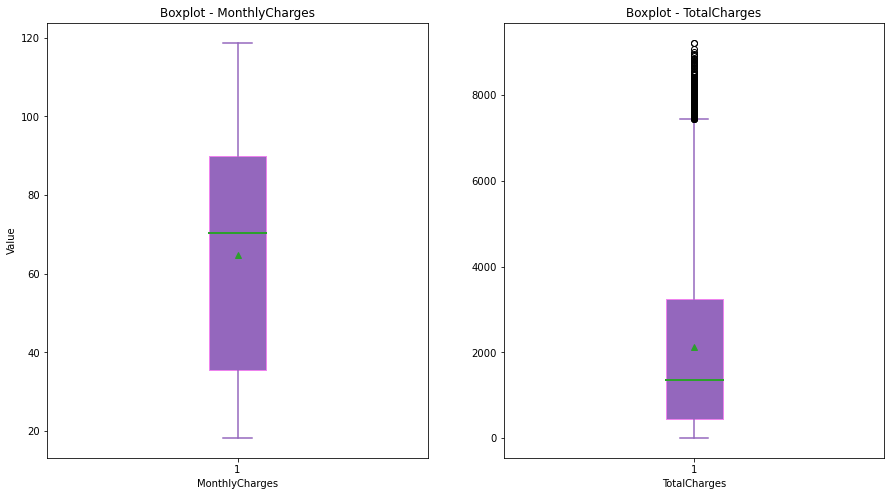

In [19]:
fig = plt.figure(figsize=(15,8))
ax = fig.subplots(nrows=1, ncols=2)
ax[0].boxplot(contract.MonthlyCharges,
              patch_artist=True,
              showmeans=True, 
              showfliers=True,  
              medianprops={"color": "C2", "linewidth": 2},
              boxprops={"facecolor": "C4", "edgecolor": "violet",
                          "linewidth": 1}, whiskerprops={"color": "C4", "linewidth": 1.5},
              capprops={"color": "C4", "linewidth": 1.5})
ax[0].set_title('Boxplot - MonthlyCharges')
ax[0].set_xlabel('MonthlyCharges')
ax[0].set_ylabel('Value')
ax[1].boxplot(contract.TotalCharges, 
              patch_artist=True,
              showmeans=True, 
              showfliers=True,  
              medianprops={"color": "C2", "linewidth": 2},
              boxprops={"facecolor": "C4", "edgecolor": "violet",
                          "linewidth": 1}, whiskerprops={"color": "C4", "linewidth": 1.5},
                capprops={"color": "C4", "linewidth": 1.5})
ax[1].set_title('Boxplot - TotalCharges')
ax[1].set_xlabel('TotalCharges')
plt.show();

In [20]:
contract.TotalCharges.describe()['75%']

3236.6899999999996

In [21]:
Q3 = contract.TotalCharges.describe()['75%']
Q1 = contract.TotalCharges.describe()['25%']
IQR = Q3-Q1
print('Количество аномалий в столбце TotalCharges: {0:.3}%'.\
     format(contract.loc[contract['TotalCharges'] > (1.5*IQR+Q3)].shape[0]*100/contract.shape[0]))

Количество аномалий в столбце TotalCharges: 2.77%


In [22]:
contract.loc[contract['TotalCharges'] > (1.5*IQR+Q3)].shape[0] #аномальных строк

195

2.77 процента данных - это не малый процент данных. 195 строк. Вероятно, просто имеются те люди, у которых большой пакет подписок или те клиенты, которые были от начала существования компании, из-за чего их Total стал велик.

In [23]:
check_id = contract.loc[contract['TotalCharges'] > (1.5*IQR+Q3)].sample(5)['customerID'].values

for i in check_id:
    display(contract.loc[contract['customerID'] == i])
    display(internet.loc[internet['customerID'] == i])
    print('-'*120)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5022,2599-CIPQE,2014-03-01,2020-02-01,Two year,No,Credit card (automatic),109.3,7760.3


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3919,2599-CIPQE,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes


------------------------------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1187,8089-UZWLX,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),104.05,7904.68


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
947,8089-UZWLX,Fiber optic,No,No,Yes,No,Yes,Yes


------------------------------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3075,5569-IDSEY,2014-03-01,2020-02-01,One year,Yes,Bank transfer (automatic),105.7,7654.79


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2407,5569-IDSEY,Fiber optic,No,Yes,Yes,No,Yes,Yes


------------------------------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
198,7255-SSFBC,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),112.25,8324.46


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
156,7255-SSFBC,Fiber optic,No,Yes,Yes,Yes,Yes,Yes


------------------------------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4397,7663-YJHSN,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),103.95,7634.09


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3432,7663-YJHSN,Fiber optic,Yes,Yes,Yes,Yes,Yes,No


------------------------------------------------------------------------------------------------------------------------


Действительно, данные клиенты имею все (почти все подписки), а также являются клиентами преимущественно с 2014 года. Отсюда и высокий показатель Total. Найденные в качестве аномалий строки удалять не будем.

Пункт 1.3


In [24]:
contract.sample()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2213,5197-YPYBZ,2019-02-01,2020-02-01,Two year,No,Credit card (automatic),25.25,306.03


In [25]:
contract['AllDate'] = (contract['EndDate'] -  contract['BeginDate']).dt.days
contract.sample()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,AllDate
6093,7110-BDTWG,2014-03-01,2020-02-01,Two year,Yes,Electronic check,47.05,3340.55,2163


In [26]:
contract.corr()

,MonthlyCharges,TotalCharges,AllDate
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
AllDate,0.220054,0.821746,1.000000


Добавили новый столбец, можем убрать даты. Как признаки они не подойдут. Между столбцами с выплатами ежемес. и всеми явной линейной зависимости нет. Оставим оба признака.

In [27]:
contract.drop(['PaperlessBilling', 'PaymentMethod'], axis=1, inplace=True)

Данные столбцы неинформативны:

- `PaperlessBilling`
- `PaymentMethod`

In [28]:
internet.sample()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
304,6862-CQUMB,Fiber optic,No,Yes,No,No,Yes,Yes


Оставим все столбцы в этом датасете.

In [29]:
phone.sample()

,customerID,MultipleLines
2766,5897-ZYEKH,Yes


Оставим все столбцы в этом датасете.

In [30]:
personal.sample()

,customerID,gender,SeniorCitizen,Partner,Dependents
4137,7777-UNYHB,Female,No,Yes,Yes


Оставим все столбцы в этом датасете.

In [31]:
df = contract.merge(internet, how='left', on='customerID')\
    .merge(phone, how='left', on='customerID')\
    .merge(personal, how='left', on='customerID')
df.head()

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,AllDate,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,DSL,No,Yes,No,No,No,No,NaN,Female,No,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,2071.84,1036,DSL,Yes,No,Yes,No,No,No,No,Male,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,53.85,226.17,123,DSL,Yes,Yes,No,No,No,No,No,Male,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,No,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,70.70,353.50,153,Fiber optic,No,No,No,No,No,No,No,Female,No,No,No


In [32]:
#создали таргет
df['Leave'] = pd.Series([1]*df.shape[0])
df.loc[df['EndDate'] == '2020-02-01', 'Leave'] = 0

In [33]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
MonthlyCharges         0
TotalCharges           0
AllDate                0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
Leave                  0
dtype: int64

Образовались пропуски после объединения, так как не все клиенты имеют подключение различных услуг и тп.
Следовательно все пропуски следует заменить на *No*.

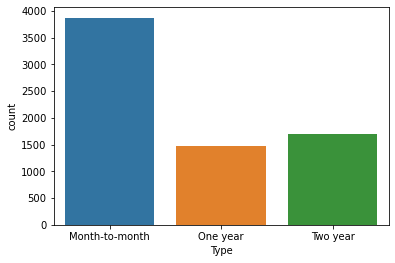

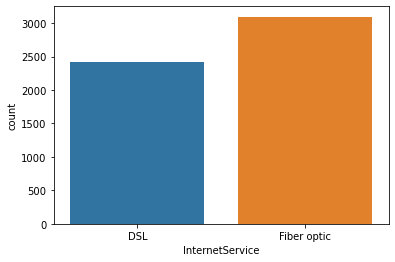

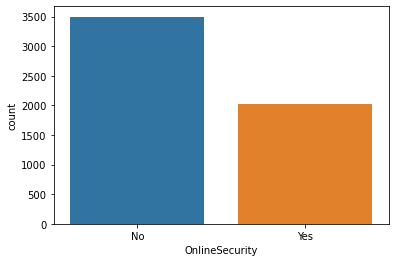

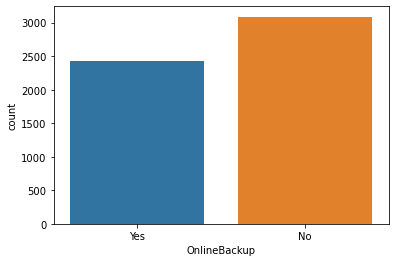

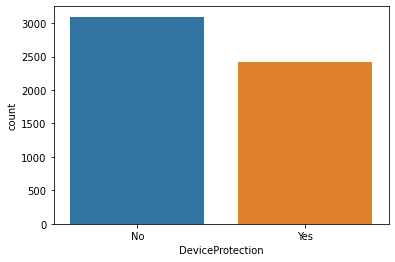

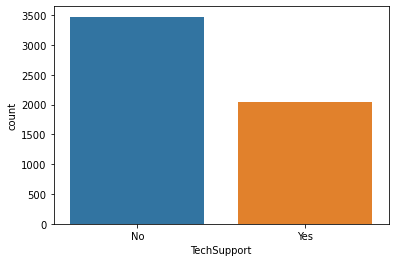

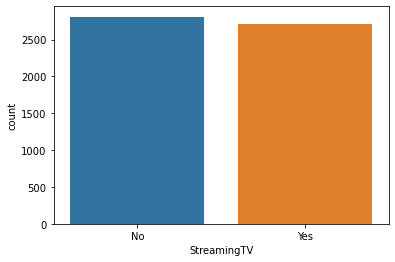

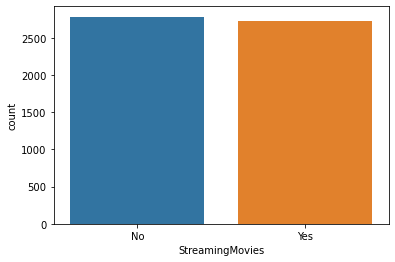

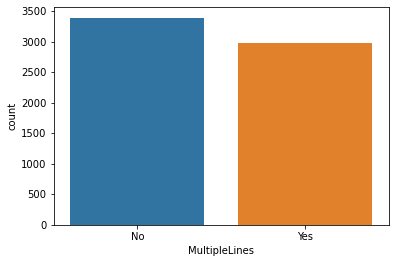

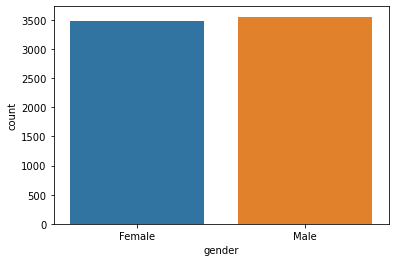

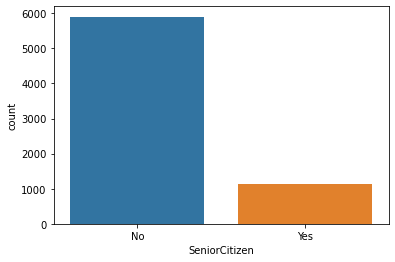

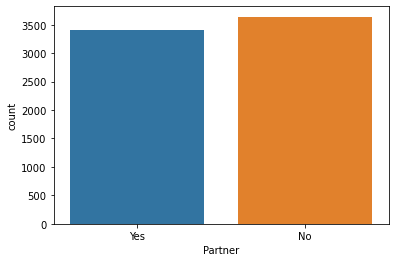

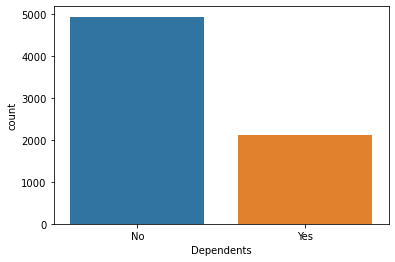

In [34]:
df1 = df.select_dtypes(exclude=[np.int, np.float]).drop(['customerID','BeginDate','EndDate'],axis=1)
for i, col in enumerate(df1.columns):
    plt.figure(i)
    sns.countplot(x=col, data=df1)

In [35]:
df.fillna('No', inplace=True)
df.head()

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,AllDate,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,Leave
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,DSL,No,Yes,No,No,No,No,No,Female,No,Yes,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,2071.84,1036,DSL,Yes,No,Yes,No,No,No,No,Male,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,53.85,226.17,123,DSL,Yes,Yes,No,No,No,No,No,Male,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,DSL,Yes,No,Yes,Yes,No,No,No,Male,No,No,No,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,70.70,353.50,153,Fiber optic,No,No,No,No,No,No,No,Female,No,No,No,0


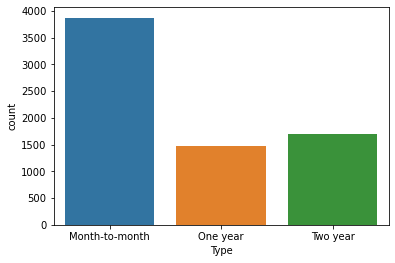

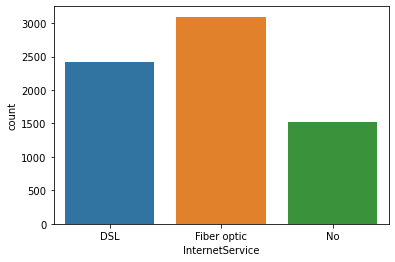

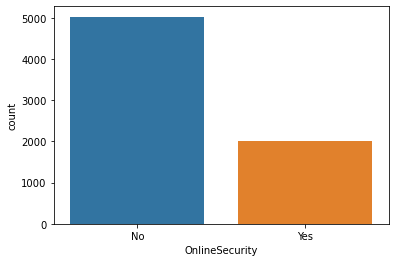

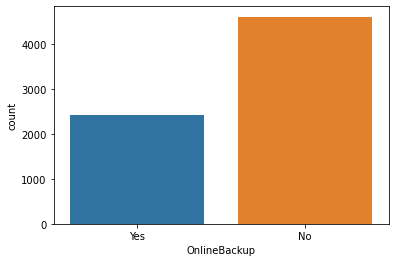

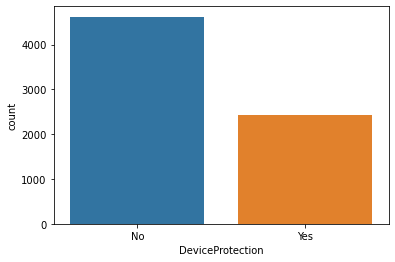

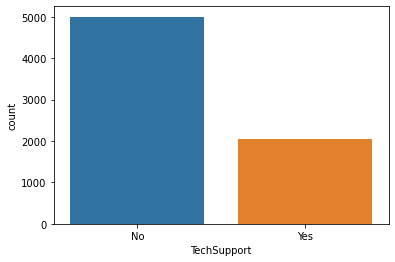

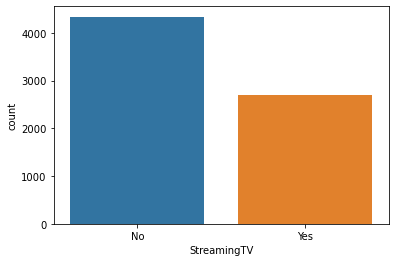

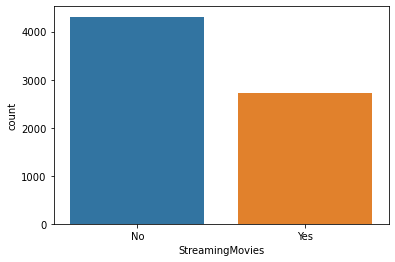

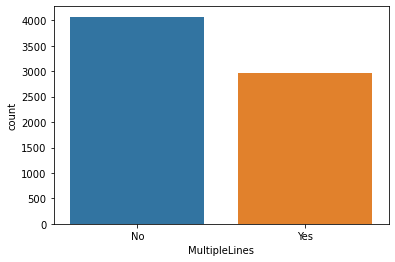

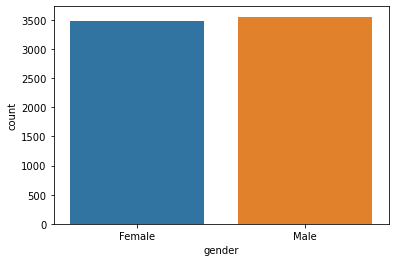

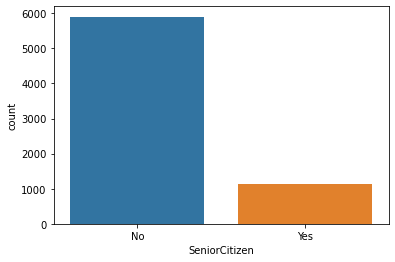

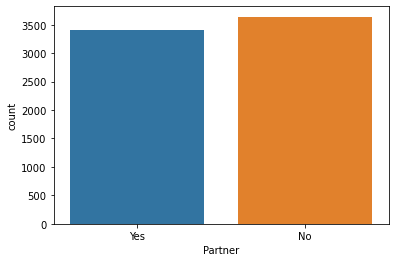

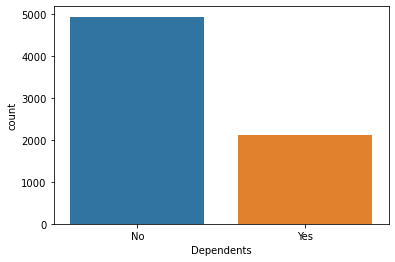

In [36]:
df1 = df.select_dtypes(exclude=[np.int, np.float]).drop(['customerID','BeginDate','EndDate'],axis=1)
for i, col in enumerate(df1.columns):
    plt.figure(i)
    sns.countplot(x=col, data=df1)

После заполнения пропусков распределения не изменились. Не было создано искуственных данных или каких-либо аномалий.

### Шаг 2

Пункт 2.1

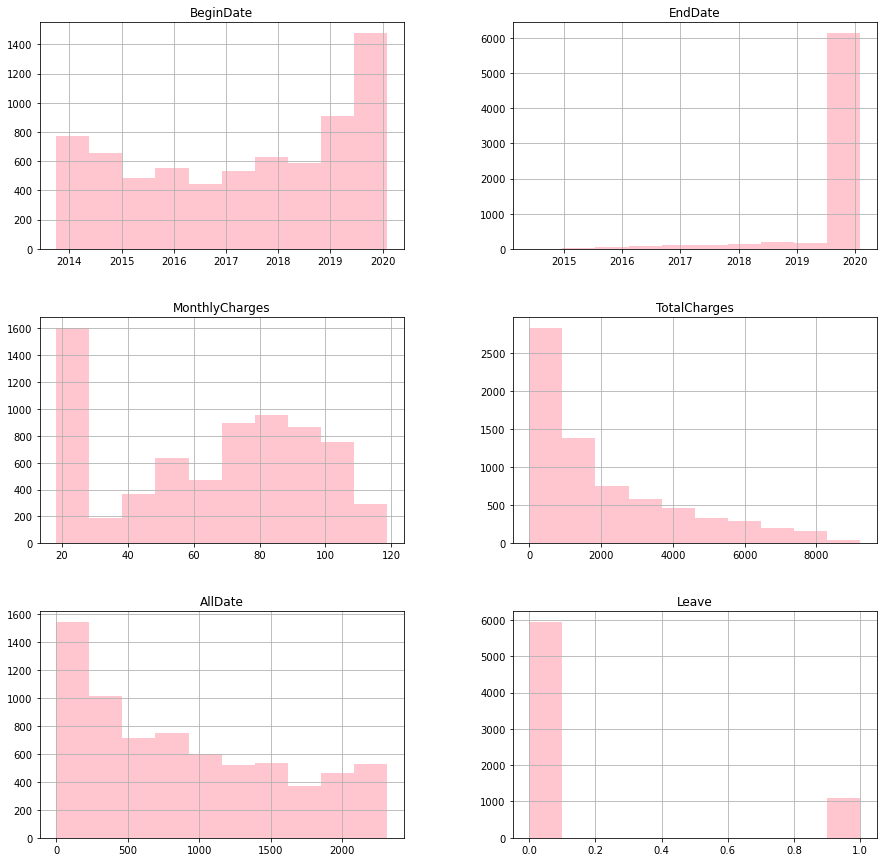

In [37]:
df.hist(figsize=(15,15), color='pink', alpha=0.9);

**Распределения столбцов показали:**
1. Спад и прирост новых клиентов: с 2014 по первое полугодие 2016 - спад, а далее рост.
2. Рост ухода клиентов (за исключением пика, тк это искуственные данные)
3. Большинство клиентов имеют минимальный ежемесячный тариф. Значение в Total - >4000 клиентов заплатил комании каждый менее 2000. 
4. Распределение AllDate показывает, что большинство "свежих" клиентов, которые пробыли в компании не так много времени. Постоянных клиентов более 500.
5. Распределение классов неравномерное. 6 к 1. Наша выбранная метрика устойчива с дисбалансу. Так что проводить "выравнивание" не будем.

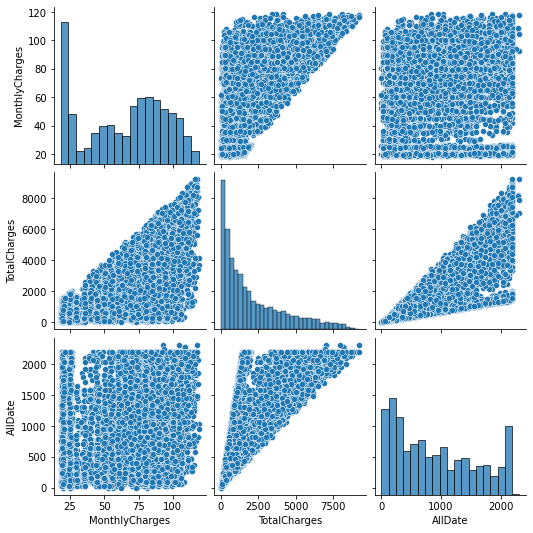

In [38]:
sns.pairplot(df.drop('Leave', axis=1));

У `TotalCharges` явная асимптота. Есть корреляция между `AllDate`и `TotalCharges`.

Далее, посмотрим подробнее на некторые распределения.

In [39]:
month_dist = df.pivot_table(index='BeginDate', values='Leave', aggfunc=['count'])\
    .join(df.loc[df['EndDate'] != '2020-02-01'].pivot_table(index='EndDate', values='Leave', aggfunc=['count']),
            how='left',
            lsuffix='_begin',
            rsuffix='_end')
month_dist.columns  = ['count_begin', 'count_end']
month_dist.fillna(0, inplace=True)
month_dist.sample(5)

,count_begin,count_end
BeginDate,,
2015-02-01,80,4.0
2016-08-01,67,11.0
2019-04-01,108,24.0
2015-04-01,69,2.0
2016-11-01,50,13.0


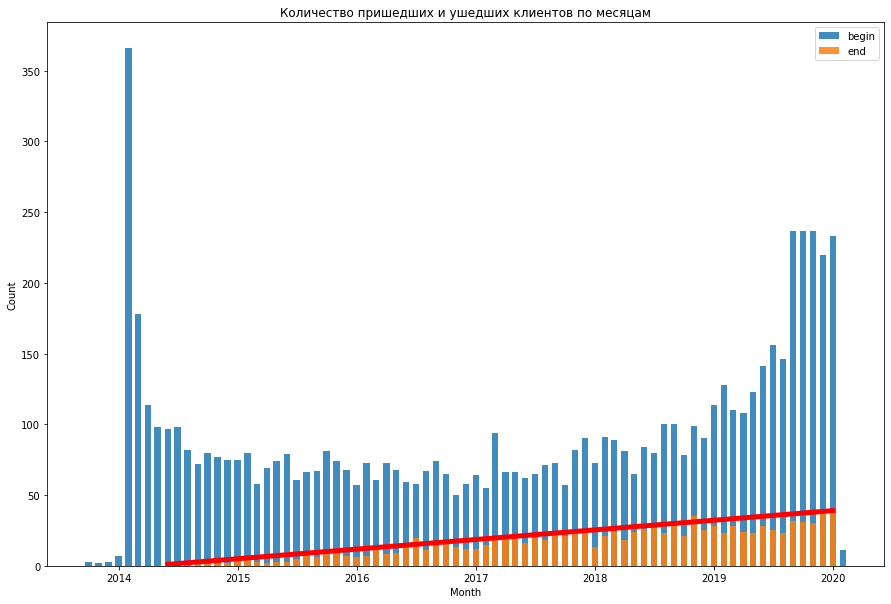

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

ax1 = ax.bar(month_dist.index, height=month_dist['count_begin'], width=20, alpha=0.85)
ax2 = ax.bar(month_dist.index, height=month_dist['count_end'], width=20, alpha=0.85)
ax.plot([pd.to_datetime('2014-06-01', format='%Y-%m-%d'),
         pd.to_datetime('2020-01-01', format='%Y-%m-%d')], 
        [1, 39], 
        linewidth=5,
        color='red')
plt.title('Количество пришедших и ушедших клиентов по месяцам')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend([ax1, ax2], ['begin', 'end'])
plt.show()

В начале 2014 года наблюдается резкий скачок количества пользователей. В 2019 начался рост пользователей. **Отток клиентов имеет линейную динамику**.

In [41]:
type_dist = df[df['EndDate'] !='2020-02-01'].pivot_table(index='Type', values=['customerID'], aggfunc=['count'])\
    .merge(df.pivot_table(index='Type', values=['customerID'], aggfunc=['count']),
           how='left',
           left_on = 'Type',
           right_on = 'Type')
type_dist.columns  = ['end', 'all']
type_dist['percent'] = (type_dist['end']/type_dist['all'])*100
type_dist

,end,all,percent
Type,,,
Month-to-month,407,3875,10.503226
One year,313,1473,21.249151
Two year,381,1695,22.477876


**Люди, которые платят каждый месяц реже уходят, чем те, которые платят раз в год или два.**

In [42]:
df.corr()

,MonthlyCharges,TotalCharges,AllDate,Leave
MonthlyCharges,1.000000,0.630440,0.220054,0.154286
TotalCharges,0.630440,1.000000,0.821746,0.052175
AllDate,0.220054,0.821746,1.000000,0.016578
Leave,0.154286,0.052175,0.016578,1.000000


<AxesSubplot:>

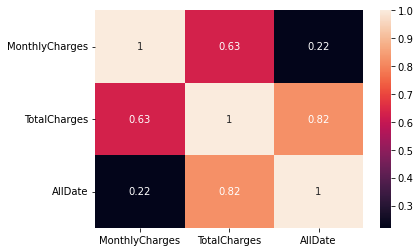

In [43]:
sns.heatmap(df.drop('Leave', axis=1).corr(), annot=True)

Большая корреляция между `AllDate` и `TotalCharges`, что логично. Чем дольше человек является клиентом, тем больше денежных средств он заплатил за весь период. Также, как уже было отмечено раннее, есть корреляция между `MonthlyCharges` и `TotalCharges`.

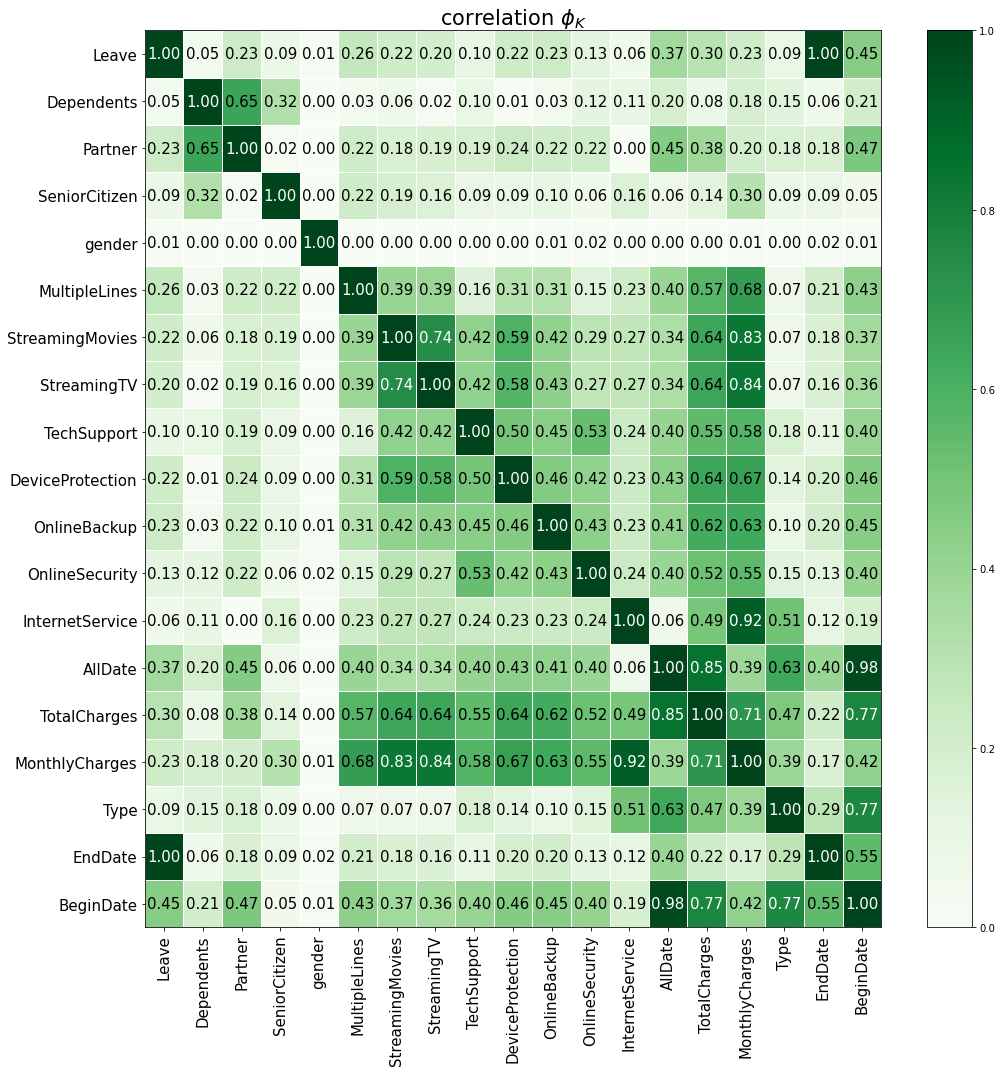

In [44]:
phik_overview = df.drop('customerID', axis=1).phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'AllDate', 'Leave'])
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 15))
plt.tight_layout()

`MontlyCharges`,`TotalCharges` имеют множество корреляция с различными категориальными признаками. Корреляции таргета слабые со всеми признаками.

### Шаг 3

Пункт 3.1

In [45]:
df.head()

,customerID,BeginDate,EndDate,Type,MonthlyCharges,TotalCharges,AllDate,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,Leave
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,29.85,31.04,31,DSL,No,Yes,No,No,No,No,No,Female,No,Yes,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,56.95,2071.84,1036,DSL,Yes,No,Yes,No,No,No,No,Male,No,No,No,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,53.85,226.17,123,DSL,Yes,Yes,No,No,No,No,No,Male,No,No,No,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,42.30,1960.60,1371,DSL,Yes,No,Yes,Yes,No,No,No,Male,No,No,No,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,70.70,353.50,153,Fiber optic,No,No,No,No,No,No,No,Female,No,No,No,0


Подготовим признаки и тагрет.

In [46]:
features = df.drop(['customerID', 'BeginDate', 'EndDate', 'Leave'], axis=1)
target = df['Leave']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)


Пункт 3.2

In [48]:
#категориальные признаки
ohe_features_clf = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_clf)

['Type', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']


In [49]:
#численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'TotalCharges', 'AllDate']

In [50]:
X_train_clf = X_train.copy()
X_test_clf = X_test.copy()

In [51]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(X_train_clf[ohe_features_clf])

X_train_clf[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_clf[ohe_features_clf])


X_train_clf = X_train_clf.drop(ohe_features_clf, axis=1)

Незабываем *drop='first'* удаляет первый признак из закодированных, таким образом обходим dummy-ловушку и задаём *handle_unknown='ignore'* игнорируется ранее невстречающиеся значения признака.

In [52]:
scaler = StandardScaler()
X_train_clf[num_features] = scaler.fit_transform(X_train_clf[num_features])
X_train_clf.head()

,MonthlyCharges,TotalCharges,AllDate,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes
1214,0.708300,-0.023713,-0.323653,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
827,-1.299800,-0.824187,-0.680887,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
6266,0.636879,0.346625,0.210734,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1010,-0.482608,-0.921512,-1.171352,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4397,1.304584,2.592822,1.901740,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [53]:
X_test_clf[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_clf[ohe_features_clf])

X_test_clf= X_test_clf.drop(ohe_features_clf, axis=1)

X_test_clf[num_features] = scaler.transform(
    X_test_clf[num_features]
)

X_test_clf.head()

,MonthlyCharges,TotalCharges,AllDate,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes
1340,-0.286615,-0.992164,-1.306047,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
138,-1.497454,-0.446538,1.237050,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4357,-1.469218,-0.835148,-0.636965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1776,-1.318071,-0.129974,1.901740,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
3509,-0.657009,-0.970022,-1.260661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Шаг 4

In [54]:
params = dict(penalty=['l1', 'l2', 'elasticnet', 'none'], 
                     solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                     C=[10,100,1000], 
                     max_iter=[100,1000,5000,10000]
             )
rscv = RandomizedSearchCV(LogisticRegression(random_state=RANDOM_STATE), 
                          params, 
                          random_state=RANDOM_STATE, 
                          scoring='roc_auc', 
                          cv=5)
clf = rscv.fit(X_train_clf, y_train)

print('Best hyperparameters are: ', clf.best_params_)
print('Best score is: ', clf.best_score_)

Best hyperparameters are:  {'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'C': 10}
Best score is:  0.7618157149338767


In [55]:
params = dict(n_estimators = list(range(100,2100,100)), 
              learning_rate = [0.01, 0.015, 0.025, 0.05, 0.1], 
              max_depth = [3, 5, 6, 7, 9, 12, 15, 17, 25], 
              boosting_type = ['gbdt', 'Dart', 'Rf', 'Goss']
             )
rscv = RandomizedSearchCV(LGBMClassifier(random_state=RANDOM_STATE), 
                          params, 
                          random_state=RANDOM_STATE, 
                          scoring='roc_auc', 
                          cv=5)
lgbm_clf = rscv.fit(X_train_clf, y_train)
print('Best hyperparameters are: ', lgbm_clf.best_params_)
print('Best score is: ', lgbm_clf.best_score_)

Best hyperparameters are:  {'n_estimators': 1700, 'max_depth': 5, 'learning_rate': 0.1, 'boosting_type': 'Dart'}
Best score is:  0.8671840506020946


Посмотрели на две модели: линейную и бустинговую. Лучшей по кросс-валидации стала бустинговая модель. Это LGBMClassifier.  <br>
Параметры данной модели {'n_estimators': 1700, 'max_depth': 5, 'learning_rate': 0.1, 'boosting_type': 'Dart'}. <br>
Значение целевой метрики: 0.8671840506020946. <br>
Проверим ее на тесте.

### Шаг 5

In [56]:
roc_auc_score(y_test, lgbm_clf.predict_proba(X_test_clf)[:,1])

0.8961709310165107

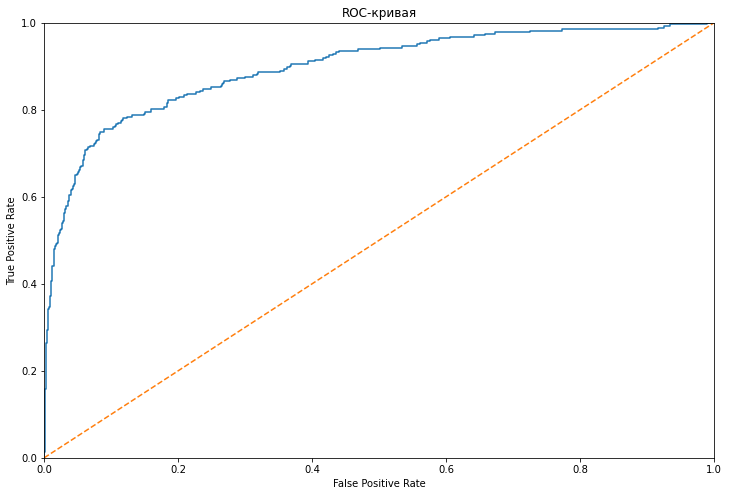

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, lgbm_clf.predict_proba(X_test_clf)[:, 1])

plt.figure(figsize=(12,8))
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

На тесте модель показала себя лучше. **Значение метрики AUC-ROC: 0.8962.**

### Шаг 6

In [58]:
lgbm_params = lgbm_clf.best_params_
lgbm_params

{'n_estimators': 1700,
 'max_depth': 5,
 'learning_rate': 0.1,
 'boosting_type': 'Dart'}

In [59]:
lgbm_model = LGBMClassifier(boosting_type=lgbm_params['boosting_type'],
                            learning_rate=lgbm_params['learning_rate'], 
                            max_depth=lgbm_params['max_depth'], 
                            n_estimators=lgbm_params['n_estimators'])
lgbm_model.fit(X_train_clf, y_train)
lgbm_model.feature_importances_

array([ 8434,  6809, 13072,  1059,  1286,   118,    26,   724,   595,
         683,   603,   476,   581,   702,   953,   466,   985,   958])

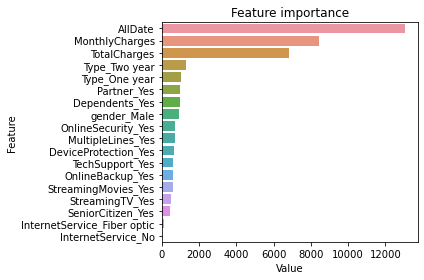

In [60]:
feature_importance = lgbm_model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, X_train_clf.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

Самыми важными признаками оказались `TotalCharges`, `AllDate`, `MonthlyCharges`.

In [62]:
lgbm_clf

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=80523),
                   param_distributions={'boosting_type': ['gbdt', 'Dart', 'Rf',
                                                          'Goss'],
                                        'learning_rate': [0.01, 0.015, 0.025,
                                                          0.05, 0.1],
                                        'max_depth': [3, 5, 6, 7, 9, 12, 15, 17,
                                                      25],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
                                                         2000]},
                   random_state=80523, 

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, lgbm_model.predict(X_test_clf)).ravel()
confus_matrix = pd.DataFrame(confusion_matrix(y_test, lgbm_model.predict(X_test_clf)))
display(confus_matrix)
print('TN:', tn,'\nFP:', fp,'\nFN:', fn, '\nTP:', tp)

,0,1
0,1444,34
1,132,151


TN: 1444 
FP: 34 
FN: 132 
TP: 151


34 пользователю предложили промокоды, но они не собирались уходить. <br>
132 пользователю ничего не предложили, и они ушли. <br>
1444 пользователю не предложили промокоды и они ушли. <br>
151 предложили промокоды и они остались.

### Отчет по проделанной работе

**В ходе проделанной работы мы выполнили разведывательный, первичный анализ, после которого привели наши данные в порядок. Далее провели EDA и сделали важные выводы для бизнеса:**
- Люди, которые платят каждый месяц реже уходят, чем те, которые платят раз в год или два.
- Большинство клиентов имеют минимальный ежемесячный тариф. Необхожимо уделять достаточное время этой категории пользователей.
- Большинство "свежих" клиентов, которые пробыли в компании не так много времени. Постоянных клиентов более 500. Необходимо их удерживать.
-  Отток клиентов имеет линейную динамику. Резких пиков роста оттока не наблюдается. <br>

**Ключевые шаги:**
1. Подготовка данных 
2. EDA (сделали многие выводы о бизнесе)
3. Подготовка фичей (провели анализ фичей, которые в полной мере опишут модель)
4. Создание модели (выбрали лучшую модель, отвечающую высоким метрикам)

Основное трудностью было - работа с категориальными признаками. Тк их много. Была задача анализа корреляции. Решением было использовать библиотеку phik, в которой есть возможность рассмотреть корреляцию между категориальными признаками.

Для модели использовали множество признаков. Это все признаки из таблицы `internet`, `phone`, и частично выбрали из `contract` и `personal`. Убрали неиформативные признаки типа даты, имен и тп.
Создали дополнительные фичи: `AllDate`, а также целевой признак `Leave`.  Самыми важными признаками оказались `TotalCharges, Type, MonthlyCharges`.

**Подготовили данные для подачи в модель. Выполнили их нормализацию, стандартизацию, а также кодирование. Обучили несколько моделей и подобрали для них гиперпараметры. Провели тест модели на тестовых данных. Провели анализ важности признаков и построили матрицу ошибок.** <br>

- Лучшей по кросс-валидации стала бустинговая модель. LGBMClassifier. Параметры данной модели `{'n_estimators': 1700, 'max_depth': 5, 'learning_rate': 0.1, 'boosting_type': 'Dart'}`. Значение целевой метрики: 0.8672.
- На тесте модель показала себя лучше. Значение метрики AUC-ROC: 0.8962.